# What

As discussed in #146 it seems that a searching problem is what this will turn into.
After the creation of #163 this branch and notebook is the base for further work.

Using a vector dba nd rag could be the best way for people to search through all of the reports.

Currently **this** notebook has a few things:
- Getting and preparing the datasets which will be used by other notebooks
- A simple test of vector database and RAg (this is now deprecated)

There are other notebooks in this folder which are:
- [#165_basic_safety_issue_rag.ipynb](#165_basic_safety_issue_rag.ipynb) which is to answer #165 and does waht hte title suggests

## Modules

In [1]:
# from me
from engine.OpenAICaller import openAICaller
from engine.Extract_Analyze import ReportExtracting
import engine.Modes as Modes

# third party

from importlib import reload

import lancedb
import pyarrow as pa

import yaml
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()


import torch
from sentence_transformers import SentenceTransformer
import voyageai
from tenacity import retry, stop_after_attempt, wait_random_exponential
from transformers import AutoTokenizer

from dotenv import load_dotenv


# built in
import os

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import multiprocessing
import random
import regex as re

load_dotenv('../../.env')


True

# Getting data

The initial idea would be to have all of the important text inside the vetor database. This means that the searching could happen with most of the report.

In [7]:
output_folder = '../../output'
reports = [dir for dir in os.listdir(output_folder) if os.path.isdir(os.path.join(output_folder, dir))]

## Text

Since I am going to want to look at all aspects of the report this means that I need to get all of the reports

In [8]:
report_text = []

for report in reports:

    report_text_path = os.path.join(output_folder, report, f'{report}.txt')
    
    if not os.path.exists(report_text_path):
        continue

    with open(report_text_path, 'r') as f:
        text = f.read()

    if text == None:
        continue

    report_text.append({
        'report_id': report,
        'text': text
    })

report_text_df = pd.DataFrame(report_text)

report_text_df

,report_id,text
0,2001_010,﻿ \n \n \n \n \nReport 01-010 \n \nEmbraer EM...
1,2019_106,﻿ \n \n \n \n \nFinal report \nRail inquiry ...
2,2013_107,﻿ \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...
3,2005_107,﻿ \nTRANSPORT ACCIDENT INVE STIGATION COMMISS...
4,2020_102,﻿ \n \n \n \nFinal report \nRail inquiry RO -...
...,...,...
496,2000_015,﻿ \n \n \n \n \nReport 00 -015 \n \nPiper PA28...
497,2004_202,﻿TRANSPORT ACCIDENT INVE STIGATION COMMISSION ...
498,2006_002,﻿ \nTRANSPORT ACCIDENT INVESTIGATION COMMISSI...
499,2002_122,﻿ \nTRANSPORT ACCIDENT INVESTIGATION COMMISSI...


## Important text

In [9]:
# load all important text

with open('../../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

important_text_extractor = ReportExtracting.ReportExtractingProcessor(output_folder, config['engine']['output']['reports'])

important_texts = []

for report in reports:

    text = important_text_extractor.get_important_text(report, False)

    if text == None:
        continue

    important_texts.append({
        'report_id': report,
        'important_text': text
    })

important_texts_df = pd.DataFrame(important_texts)

important_texts_df

  Getting important text... for 2001_010
  Getting important text... for 2019_106
  Getting important text... for 2013_107
  Getting important text... for 2005_107
  Getting important text... for 2020_102
  Getting important text... for 2011_003
  Getting important text... for 2012_105
  Getting important text... for 2019_202
  Getting important text... for 2003_002
  Getting important text... for 2001_107
  Getting important text... for 2022_102
  Getting important text... for 2004_102
  Getting important text... for 2002_105
  Getting important text... for 2002_013
  Getting important text... for 2010_010
  Getting important text... for 2004_219
  Getting important text... for 2005_210
  Getting important text... for 2005_206
  Getting important text... for 2008_110
  Getting important text... for 2013_011
  Getting important text... for 2009_002
  Getting important text... for 2002_206
  Getting important text... for 2015_103
  Getting important text... for 2002_114
  Getting import

,report_id,important_text
0,2001_010,<< Page 4 >>\n 1.5 Other information \n \n1.5...
1,2019_106,<< Page 6 >>\n Final Report RO -2019 -106 3 An...
2,2013_107,<< Page 9 >>\n 4. Analysis \n4.1. Introductio...
3,2020_102,<< Page 8 >>\n \n 3 Analysis \nIntroduction ...
4,2011_003,<< Page 14 >>\n Final Report 11 -003 4. Analys...
...,...,...
351,2020_104,<< Page 7 >>\n 3 Analysis \nIntroduction \n3...
352,2004_211,<< Page 7 >>\n 1.6.4 The fracture along weld ...
353,2000_015,<< page 8 >>\n Fit and proper person \n \n1.1...
354,2006_002,<< Page 4 >>\n 1.7.4 The other operator said t...


### Token count

In [7]:
important_texts_df['gpt-3.5_tokens'] = important_texts_df['important_text'].apply(lambda x: openAICaller.get_tokens([x])[0])

95.79% are under 13333.33 tokens. With a total sum of 1767049 tokens.


,report_id,important_text,gpt-3.5_tokens
23,2009_201,<< Page 24 >>\n Report 09 -201 4. Analysis \n...,14258
49,2002_101,<< Page 4 >>\n Analysis 1 \n \n1. The locomot...,22089
62,2002_116,<< Page 7 >>\n 1.2.12 The track evaluation car...,28898
82,2007_207,<< Page 59 >>\n 2 Analysis \n \n2.1 General c...,16281
120,2002_102,<< Page 4 >>\n Analysis 1 \n \n1. The locomot...,22089
121,2022_201,<< Page 17 >>\n Final Report MO -2022 -201 3 A...,19842
137,2006_204,<< Page 16 >>\n 1.3 Analysis of the constructi...,25489
148,2014_006,<< Page 15 >>\n Final report AO -2014 -006 4....,15404
149,2002_103,<< Page 4 >>\n Analysis 1 \n \n1. The locomot...,22089
162,2013_203,<< Page 8 >>\n Final report MO -2013 -203 \n A...,22350


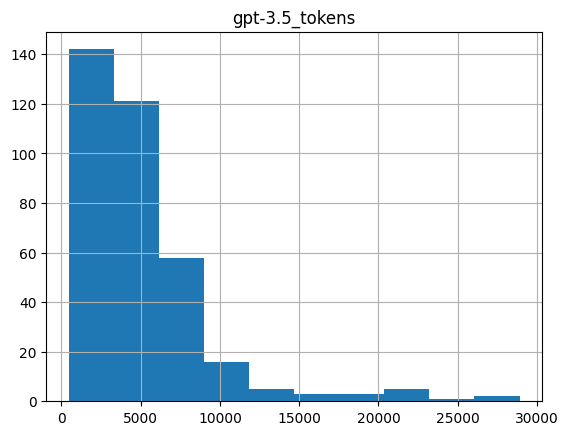

In [8]:
important_texts_df.hist(column='gpt-3.5_tokens')

# Check what token cutoff is reasonable

max_tokens = 16_000/1.2

print(f'{important_texts_df[important_texts_df["gpt-3.5_tokens"] < max_tokens].shape[0] / important_texts_df.shape[0] * 100:.2f}% are under {max_tokens:.2f} tokens. With a total sum of {important_texts_df["gpt-3.5_tokens"].sum()} tokens.')

important_texts_df[important_texts_df['gpt-3.5_tokens'] > max_tokens]



## Safety issues

In [9]:
safety_issues_df = pd.read_csv('data/safety_issues.csv')[['report_id', 'safety_issue']].rename({'safety_issue': 'si'}, axis = 1)
safety_issues_df['si'] = safety_issues_df['si'].apply(lambda x: x.strip())

safety_issues_df

,report_id,si
0,2001_010,The generally worn and damaged condition of th...
1,2001_010,While a number of door defects had been report...
2,2019_106,No procedures were in place to direct train cr...
3,2013_107,"The high incidence of brake block replacement,..."
4,2013_107,The visual inspection regime for wheel-bearing...
...,...,...
1862,2002_122,The brake rigging safety wire was designed to ...
1863,2002_122,Given the number of derailments caused by deta...
1864,2002_122,Train 215 should not have been dispatched from...
1865,2002_122,The dispatch of Train 215 without a full inspe...


# Preparing data

In [11]:
all_reports_df = pd.read_pickle('data/reports_extracted_sections.pkl')
all_reports_df

,report_id,text,content_section,extracted_sections,missing_sections,percent_missing,important_text,gpt-3.5_tokens
0,2001_010,﻿ \n \n \n \n \nReport 01-010 \n \nEmbraer EM...,Contents \n \nData Summary .....................,section ...,[2.9],0.028571,<< Page 4 >>\n 1.5 Other information \n \n1.5...,1173
1,2019_106,﻿ \n \n \n \n \nFinal report \nRail inquiry ...,Contents \n1 Executive summary ................,section ...,[],0.000000,<< Page 6 >>\n Final Report RO -2019 -106 3 An...,3627
2,2013_107,﻿ \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,Contents \nAbbreviations ......................,section ...,[],0.000000,<< Page 9 >>\n 4. Analysis \n4.1. Introductio...,4826
3,2020_102,﻿ \n \n \n \nFinal report \nRail inquiry RO -...,Contents \n1 Executive summary ................,section ...,[],0.000000,<< Page 8 >>\n \n 3 Analysis \nIntroduction ...,3435
4,2011_003,﻿ \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,Contents \nAbbreviations ......................,section ...,[],0.000000,<< Page 14 >>\n Final Report 11 -003 4. Analys...,12770
...,...,...,...,...,...,...,...,...
349,2020_104,﻿ \n \n \n \n \nFinal Report \nRail inquiry...,Contents \n1 Executive summary ................,section ...,[],0.000000,<< Page 7 >>\n 3 Analysis \nIntroduction \n3...,3779
350,2004_211,﻿TRANSPORT ACCIDENT INVE STIGATION COMMISSION ...,Contents \n \nAbbreviations .....................,section ...,[],0.000000,<< Page 7 >>\n 1.6.4 The fracture along weld ...,1487
351,2000_015,﻿ \n \n \n \n \nReport 00 -015 \n \nPiper PA28...,Contents \n \nList of Abbreviations ............,section ...,[],0.000000,<< page 8 >>\n Fit and proper person \n \n1.1...,5227
352,2006_002,﻿ \nTRANSPORT ACCIDENT INVESTIGATION COMMISSI...,Contents \n \nAbbreviations .....................,section ...,[2.9],0.018182,<< Page 4 >>\n 1.7.4 The other operator said t...,761


In [15]:
all_reports_df.query('report_id == "2020_103"').loc[111, 'extracted_sections']

KeyError: 111

## Splitting document

I think something quite usueful about the vector databases will be not just finding the reports but also the specific report sections. For this I want to get a dataset that has the report represented as a strucutred document with sections and such. Then I could embed each of these and have much more fine-grained searching.

I am going to ask TAIC directly to see if they have a dataset of word documents. I have heard back and it sounds like they wont have that dataset available. I will haveto work with the report extractor and see how well that goes. think it shouldn't be too complex.


In [16]:
reload(ReportExtracting)

report_text_df['content_section'] = report_text_df.apply(lambda row: ReportExtracting.ReportExtractor(row['text'], row['report_id']).extract_contents_section(), axis=1)

report_text_df

Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents section
Error cant find the end of the contents 

,report_id,text,content_section
0,2001_010,﻿ \n \n \n \n \nReport 01-010 \n \nEmbraer EM...,Contents \n \nData Summary .....................
1,2019_106,﻿ \n \n \n \n \nFinal report \nRail inquiry ...,Contents \n1 Executive summary ................
2,2013_107,﻿ \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,Contents \nAbbreviations ......................
3,2005_107,﻿ \nTRANSPORT ACCIDENT INVE STIGATION COMMISS...,None
4,2020_102,﻿ \n \n \n \nFinal report \nRail inquiry RO -...,Contents \n1 Executive summary ................
...,...,...,...
496,2000_015,﻿ \n \n \n \n \nReport 00 -015 \n \nPiper PA28...,Contents \n \nList of Abbreviations ............
497,2004_202,﻿TRANSPORT ACCIDENT INVE STIGATION COMMISSION ...,None
498,2006_002,﻿ \nTRANSPORT ACCIDENT INVESTIGATION COMMISSI...,Contents \n \nAbbreviations .....................
499,2002_122,﻿ \nTRANSPORT ACCIDENT INVESTIGATION COMMISSI...,Contents \nAbbreviations ........................


In [18]:
def get_potential_section():
    sections = list(map(str, range(1,15)))

    subsections = [
        [
            section + '.' + str(subsection)
            for subsection in
            range(1,100)
        ]
        for section in 
        sections
    ]

    paragraphs = [
        [
            [
                subsection + '.' + str(paragraph)
                for paragraph in
                range(1,100)
            ]
            for subsection in
            section
        ]
        for section in 
        subsections
    ]

    return paragraphs

In [19]:
reload(ReportExtracting)

all_potential_sections = get_potential_section()

def extract_sections(num_sections, report_text, debug = False):
    get_parts_regex = r'(((\d{1,2}).\d{1,2}).\d{1,2})'
    
    extreactor = ReportExtracting.ReportSectionExtractor(report_text, num_sections)

    sections = []

    for section in all_potential_sections:
        if debug: print(f"Looking at section {re.search(get_parts_regex, section[0][0]).group(3)}")

        subsection_missing_count = 0
        for sub_section in section:
            sub_section_str = re.search(get_parts_regex, sub_section[0]).group(2)
            if debug: print(f" Looking at subsection {sub_section_str}")

            paragraph_missing_count = 0

            paragraphs = []
            for paragraph in sub_section:
                if debug: print(f"  Looking for paragraph {paragraph}")

                paragraph_text = extreactor.extract_section(paragraph, useLLM = False)

                if paragraph_text is None and (paragraph_missing_count > 0 or paragraph[-1] == '1'):
                    break
                elif paragraph_text is None:
                    paragraph_missing_count += 1
                    continue

                paragraphs.append({'section': paragraph, 'section_text': paragraph_text})

            if len(paragraphs) == 0:
                if debug: print(f" No paragraphs found ")
                sub_section_text = extreactor.extract_section(sub_section_str, useLLM = False)

                if sub_section_text is None and subsection_missing_count > 0:
                    if debug: print(f" No subsection found")
                    break
                elif sub_section_text is None:
                    subsection_missing_count += 1
                    continue

                sections.append({'section': sub_section_str, 'section_text': sub_section_text})
            else:
                sections.extend(paragraphs)

    df = pd.DataFrame(sections)

    if debug and df.empty: print(f"No sections extracted")

    return df

# Parallel apply function
def parallel_apply(df, func, num_sections, debug=False):
    with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
        futures = [
            executor.submit(func, num_sections, row['text'], debug) for index, row in df.iterrows()
        ]
        results = []
        for future in tqdm(futures, total=len(futures)):
            results.append(future.result())
    return results

test_df = report_text_df.sample(30, random_state=42)

report_text_df['extracted_sections'] = parallel_apply(report_text_df, extract_sections, 15, False)

report_text_df

100%|██████████| 501/501 [00:58<00:00,  8.57it/s]


,report_id,text,content_section,extracted_sections
0,2001_010,﻿ \n \n \n \n \nReport 01-010 \n \nEmbraer EM...,Contents \n \nData Summary .....................,section ...
1,2019_106,﻿ \n \n \n \n \nFinal report \nRail inquiry ...,Contents \n1 Executive summary ................,section ...
2,2013_107,﻿ \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,Contents \nAbbreviations ......................,section ...
3,2005_107,﻿ \nTRANSPORT ACCIDENT INVE STIGATION COMMISS...,None,section ...
4,2020_102,﻿ \n \n \n \nFinal report \nRail inquiry RO -...,Contents \n1 Executive summary ................,section ...
...,...,...,...,...
496,2000_015,﻿ \n \n \n \n \nReport 00 -015 \n \nPiper PA28...,Contents \n \nList of Abbreviations ............,section ...
497,2004_202,﻿TRANSPORT ACCIDENT INVE STIGATION COMMISSION ...,None,section ...
498,2006_002,﻿ \nTRANSPORT ACCIDENT INVESTIGATION COMMISSI...,Contents \n \nAbbreviations .....................,section ...
499,2002_122,﻿ \nTRANSPORT ACCIDENT INVESTIGATION COMMISSI...,Contents \nAbbreviations ........................,section ...


Here is the calculation of how many missing sections there are.

For example if it has found 4.3 and 4.5 but not 4.4 then that counts as a missing section

In [20]:
def find_missing_sections(df):

    if df.empty: return []

    # Parse sections into a list of tuples of integers
    sections = df['section'].apply(lambda x: tuple(map(int, x.split('.')))).tolist()
    
    missing_sections = []

    def section_to_str(section_tuple):
        return '.'.join(map(str, section_tuple))
    
    # Iterate through the sections to find missing sections
    for i in range(len(sections) - 1):
        current = sections[i]
        next_section = sections[i + 1]
        
        # If the current section and next section are in the same main section
        if current[0] == next_section[0]:
            # Check for gaps in the subsection
            for sub_section in range(current[1] + 1, next_section[1]):
                missing_sections.append(f"{current[0]}.{sub_section}")
        else:
            # Handle the case where we move to the next main section
            # Add missing subsections in the current main section
            for sub_section in range(current[1] + 1, 10):  # Assuming subsections go up to .9
                missing_sections.append(f"{current[0]}.{sub_section}")
            
            # Add all subsections for the main sections between current and next
            for main_section in range(current[0] + 1, next_section[0]):
                for sub_section in range(1, 10):  # Assuming subsections go up to .9
                    missing_sections.append(f"{main_section}.{sub_section}")
            
            # Add missing subsections in the next main section up to the found subsection
            for sub_section in range(1, next_section[1]):
                missing_sections.append(f"{next_section[0]}.{sub_section}")

    # Filter out the missing sections that do not have both previous and next sections
    filtered_missing_sections = []
    for section in missing_sections:
        sec_tuple = tuple(map(int, section.split('.')))
        prev_section = (sec_tuple[0], sec_tuple[1] - 1) if sec_tuple[1] > 1 else (sec_tuple[0] - 1, 9)
        next_section = (sec_tuple[0], sec_tuple[1] + 1) if sec_tuple[1] < 9 else (sec_tuple[0] + 1, 1)
        
        if section_to_str(prev_section) in df['section'].values and section_to_str(next_section) in df['section'].values:
            filtered_missing_sections.append(section)

    return filtered_missing_sections

dev_df = report_text_df.loc[0, 'extracted_sections']

report_text_df['missing_sections'] = report_text_df['extracted_sections'].apply(lambda df: find_missing_sections(df))

report_text_df['percent_missing'] = report_text_df.apply(lambda row: len(row['missing_sections']) / (len(row['extracted_sections']) + len(row['missing_sections'])) if not row['extracted_sections'].empty else 0, axis = 1)

print(f"There are {(report_text_df['percent_missing'] > 0).sum() } number of reports with missing sections")
print(f"On average {report_text_df['percent_missing'].replace(0, np.nan).mean()*100:.2f}% of sections are missing when a report is missing sections")
print(f"Total number of missing sections {sum(report_text_df['missing_sections'].apply(len))} which is {sum(report_text_df['missing_sections'].apply(len)) / sum(report_text_df['extracted_sections'].apply(len)) *100:.2f}% of total sections")


There are 98 number of reports with missing sections
On average 1.15% of sections are missing when a report is missing sections
Total number of missing sections 105 which is 0.19% of total sections


In [ ]:
# This cell is here for manually inspecting the process of section extraction.


reload(ReportExtracting)

report_id = '2014_004'

with open(f'/home/james/code/TAIC-report-summary/output/{report_id}/{report_id}.txt', 'r') as f:
    text = f.read()

sectionExtractor = ReportExtracting.ReportSectionExtractor(text, report_id)

section_str = '4.2.5'

print(sectionExtractor._get_section_start_end_regexs(section_str)[1][2])

search_bounds = sectionExtractor._get_section_search_bounds(section_str,sectionExtractor._get_section_start_end_regexs(section_str)[1])
display(text[search_bounds[0]:search_bounds[1]])

sectionExtractor.extract_section(section_str, useLLM= False)


This extraction is entierly implemented in the `ReportExtracting` modeule. I will list some of the problems that have been identified:

| problem | examples |
| --- | ---- | 
| Missing the ending of the section and getting multiple sections | 2013_107 and section 3.3 has all of the 3.4 and it is missing 3.4. |
| References to paragraphs in previous paragraphs | 2014_005 4.6.11. |
| Final paragraph with following appendices | 2011_203 with 8.2. It doesn't know when the end of the section is. |
| Missing page in PDF conversion and thus missing many subsequent section, subsections etc. | 2019_204 3.18, 2019_204 2.10, 2018_001 3.16 and 2.5, 2018_005 3.37 and 2.8 |
| End of the reports, last section | 2018_001  8.2, 2010_201 8.4, 2011_203 8.2|


## merge important text and sections togather

In [21]:
all_reports_df = report_text_df.merge(important_texts_df, on='report_id', how='inner')

for index, row in all_reports_df.iterrows():
    if row['extracted_sections'].empty:
        print(f"Deleting report {row['report_id']}")
        all_reports_df.drop(index, inplace=True)

all_reports_df.reset_index(drop=True, inplace=True)

all_reports_df.to_pickle('data/reports_extracted_sections.pkl')

all_reports_df

Deleting report 2020_103
Deleting report 2020_101


,report_id,text,content_section,extracted_sections,missing_sections,percent_missing,important_text
0,2001_010,﻿ \n \n \n \n \nReport 01-010 \n \nEmbraer EM...,Contents \n \nData Summary .....................,section ...,[2.9],0.028571,<< Page 4 >>\n 1.5 Other information \n \n1.5...
1,2019_106,﻿ \n \n \n \n \nFinal report \nRail inquiry ...,Contents \n1 Executive summary ................,section ...,[],0.000000,<< Page 6 >>\n Final Report RO -2019 -106 3 An...
2,2013_107,﻿ \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,Contents \nAbbreviations ......................,section ...,[],0.000000,<< Page 9 >>\n 4. Analysis \n4.1. Introductio...
3,2020_102,﻿ \n \n \n \nFinal report \nRail inquiry RO -...,Contents \n1 Executive summary ................,section ...,[],0.000000,<< Page 8 >>\n \n 3 Analysis \nIntroduction ...
4,2011_003,﻿ \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,Contents \nAbbreviations ......................,section ...,[],0.000000,<< Page 14 >>\n Final Report 11 -003 4. Analys...
...,...,...,...,...,...,...,...
349,2020_104,﻿ \n \n \n \n \nFinal Report \nRail inquiry...,Contents \n1 Executive summary ................,section ...,[],0.000000,<< Page 7 >>\n 3 Analysis \nIntroduction \n3...
350,2004_211,﻿TRANSPORT ACCIDENT INVE STIGATION COMMISSION ...,Contents \n \nAbbreviations .....................,section ...,[],0.000000,<< Page 7 >>\n 1.6.4 The fracture along weld ...
351,2000_015,﻿ \n \n \n \n \nReport 00 -015 \n \nPiper PA28...,Contents \n \nList of Abbreviations ............,section ...,[],0.000000,<< page 8 >>\n Fit and proper person \n \n1.1...
352,2006_002,﻿ \nTRANSPORT ACCIDENT INVESTIGATION COMMISSI...,Contents \n \nAbbreviations .....................,section ...,[2.9],0.018182,<< Page 4 >>\n 1.7.4 The other operator said t...


In [12]:
all_sections_long_df = pd.concat(all_reports_df.apply(lambda x: x['extracted_sections'].assign(report_id=x['report_id']), axis=1).tolist(), ignore_index=True)

all_sections_long_df

,section,section_text,report_id
0,1.1.1,"1.1.1 On Wednesday 31 October 2001, Air Nation...",2001_010
1,1.1.2,"1.1.2 The pilot started work at 0630, with a p...",2001_010
2,1.1.3,1.1.3 The departure from New Plymouth and the ...,2001_010
3,1.1.4,1.1.4 After leaving the holding pattern the ai...,2001_010
4,1.1.5,"1.1.5 This passenger, assisted by 2 others, wa...",2001_010
...,...,...,...
42503,4.1,4.1 As a result of its own investigations date...,2002_122
42504,4.2,4.2 On 11 March 2004 Tranz Rail advised its co...,2002_122
42505,4.3.1,4.3.1 Alstom is currently implementing an upda...,2002_122
42506,4.3.2,4.3.2 The Brake Rigging Inspection regime is c...,2002_122


In [14]:
all_sections_long_df.query('report_id == "2020_103"')

,section,section_text,report_id


# Embedding



In [7]:
def embed_documents(df, embedding_function, document_column_name, embedding_column_name, batch_size=100, max_workers=10, debug = False):
    """
    Given a dataframe with atleast the document column and embedding column name it will generate embeddins for all of the documents that dont have embeddings.pkl
    It does this by calling the embedding_function on batches of the documents.
    There is multithreading to speed up the process.

    Args:
        df: The dataframe
        embedding_function: The function that will be called to generate embeddings for documents. It must be`f([embedding]) -> [embedding]`
        document_column_name: The name of the column that contains the documents
        embedding_column_name: The name of the column that will contain the embeddings
    Returns the dataframe with the missing embeddings filled in.
    """

    # check which new columns needs to be computed, i.e 

    missing_embeddings = df[df[embedding_column_name].isna()]

    if len(missing_embeddings) == 0:
        if debug: print(f"No missing embeddings")
        return df

    section_texts = missing_embeddings[document_column_name].tolist()

    print(f"There are {len(section_texts)} missing embeddings with {len(df)} number of documents")
    
    # Split section_texts into batches of size `batch_size`
    batches = [section_texts[i:i+batch_size] for i in range(0, len(section_texts), batch_size)]

    if debug: 
        for batch in batches: print(len(batch))

    embeddings = [None] * len(missing_embeddings)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(embedding_function, batch): i for i, batch in enumerate(batches)}

        for future in tqdm(as_completed(futures), total=len(futures)):
            batch_embeddings = future.result()
            batch_index = futures[future]
            if debug:
                print(f'Looking at batch {batch_index}, with return length {len(batch_embeddings)}')
            # Place embeddings in the correct positions
            start_index = batch_index * batch_size
            end_index = start_index + len(batch_embeddings)
            if debug: print(f"Setting embeddings {start_index} to {end_index}")
            embeddings[start_index:end_index] = batch_embeddings

    embeddings = pd.Series(embeddings, index=missing_embeddings.index) 
    # Update the dataframe with the computed embeddings
    df_embedding_column = df.loc[missing_embeddings.index, embedding_column_name]
    if debug:
        display(df_embedding_column)
        print(f'Finished embedding the documents there are {len(embeddings)} embeddings, which look like:')
        display(embeddings)
        print(f'Each embedding is in {len(embeddings[missing_embeddings.index[0]])} dimensions')

    df.loc[missing_embeddings.index, embedding_column_name] = embeddings 
    
    return df

## Using sentence transformers

I have started looking at this but using sentence transformers won't work locally with models of a large enough input size to ahndle these large documents.

There are two options.

Firstly using hugging faces dedicated inference API which has been done for the safety theme genration.  
Secondly splitting the document into smaller parts so that only specific sections are extracted.

In [16]:
def embed_sections_sentence_transformers(df, model):
    torch.cuda.empty_cache()

    embeddings = model.encode(df['section_text'], show_progress_bar=True)

    list_of_embeddings = list(embeddings)

    return df.assign(extracted_section_embeddings = list_of_embeddings)

### Alibaba-NLP/gte-large-en-v1.5

This has been choosen as it has the highest retrival score on MTEB. However as they use custom code it was too difficult to get setup so it will be put on hold.

In [13]:
model = SentenceTransformer('Alibaba-NLP/gte-large-en-v1.5', trust_remote_code=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

You try to use a model that was created with version 2.7.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





README.md:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [17]:
all_reports_df['extracted_sections'] = all_reports_df['extracted_sections'].progress_apply(embed_sections_sentence_transformers, args = (model,))


  0%|          | 0/163 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

  1%|          | 2/163 [00:02<03:21,  1.25s/it]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

  2%|▏         | 3/163 [00:06<06:14,  2.34s/it]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

  2%|▏         | 4/163 [00:10<07:35,  2.87s/it]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  3%|▎         | 5/163 [00:15<09:54,  3.76s/it]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

  4%|▎         | 6/163 [00:17<08:22,  3.20s/it]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  4%|▍         | 7/163 [00:19<07:22,  2.84s/it]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  5%|▍         | 8/163 [00:24<08:59,  3.48s/it]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

  6%|▌         | 9/163 [00:28<09:40,  3.77s/it]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

  6%|▌         | 10/163 [00:32<09:21,  3.67s/it]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  7%|▋         | 11/163 [00:36<09:37,  3.80s/it]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  7%|▋         | 12/163 [00:40<09:50,  3.91s/it]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  8%|▊         | 13/163 [00:45<10:08,  4.05s/it]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  9%|▊         | 14/163 [00:52<12:22,  4.98s/it]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  9%|▉         | 15/163 [00:57<12:31,  5.08s/it]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

 10%|▉         | 16/163 [01:01<11:18,  4.61s/it]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

 10%|█         | 17/163 [01:03<09:42,  3.99s/it]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

 11%|█         | 18/163 [01:08<10:40,  4.42s/it]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

 12%|█▏        | 19/163 [01:12<10:00,  4.17s/it]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

 12%|█▏        | 20/163 [01:13<07:46,  3.27s/it]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

 13%|█▎        | 21/163 [01:16<07:34,  3.20s/it]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

 13%|█▎        | 22/163 [01:19<06:59,  2.97s/it]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

 14%|█▍        | 23/163 [01:22<07:12,  3.09s/it]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

 15%|█▍        | 24/163 [01:28<09:04,  3.92s/it]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

 15%|█▌        | 25/163 [01:30<07:45,  3.37s/it]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

 16%|█▌        | 26/163 [01:33<07:21,  3.22s/it]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

 17%|█▋        | 27/163 [01:35<06:41,  2.95s/it]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

 17%|█▋        | 28/163 [01:38<06:32,  2.90s/it]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

 18%|█▊        | 29/163 [01:40<06:07,  2.74s/it]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

 18%|█▊        | 30/163 [01:44<06:37,  2.99s/it]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

 19%|█▉        | 31/163 [01:47<06:17,  2.86s/it]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

 20%|█▉        | 32/163 [01:50<06:30,  2.98s/it]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 33/163 [01:53<06:47,  3.14s/it]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

 21%|██        | 34/163 [01:57<06:52,  3.19s/it]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

 21%|██▏       | 35/163 [01:59<06:26,  3.02s/it]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

 22%|██▏       | 36/163 [02:02<06:19,  2.99s/it]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

 23%|██▎       | 37/163 [02:06<06:55,  3.30s/it]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

 23%|██▎       | 38/163 [02:09<06:30,  3.12s/it]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

 24%|██▍       | 39/163 [02:11<05:40,  2.74s/it]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

 25%|██▍       | 40/163 [02:15<06:22,  3.11s/it]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

 25%|██▌       | 41/163 [02:17<06:02,  2.97s/it]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

 26%|██▌       | 42/163 [02:20<05:54,  2.93s/it]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

 26%|██▋       | 43/163 [02:23<05:58,  2.99s/it]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 27%|██▋       | 44/163 [02:26<05:30,  2.77s/it]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

 28%|██▊       | 45/163 [02:28<06:30,  3.31s/it]


KeyError: 'section_text'

## Using voyageai

Voyage AI seems to have the largest embedding model that can take the input up to 16,000 tokens. This is much better than offered by openai embeddings models. With this extra size it allows me to vector search the whole document and not have to split it up into chunks. Alternatively I could start experimenting with Anthropic and their model offerings.

However I have an idea of splitting the documents up into chunks and using it to provide more accurate and usual information to the LLM prompt.

In [8]:
vo = voyageai.Client(max_retries = 10)
@retry(wait=wait_random_exponential(multiplier=1, min = 1, max=60))  
def embed_with_backoff(**kwargs):
    print('trying')
    return vo.embed(**kwargs)


def embed_batch(batch):
    return vo.embed(texts = batch, model="voyage-large-2-instruct", input_type="document", truncation=False).embeddings

tokenizer = AutoTokenizer.from_pretrained('voyageai/voyage')

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


### Embeddings on long form dataframe of individual sections

In [19]:
section_embeddings_file_name = os.path.join('embeddings', 'voyageai_section_embeddings.pkl')

In [9]:
all_sections_long_df['num_tokens'] = all_sections_long_df['section_text'].apply(lambda x: len(tokenizer.tokenize(x)))

Token indices sequence length is longer than the specified maximum sequence length for this model (12018 > 4096). Running this sequence through the model will result in indexing errors


In [10]:
all_sections_long_df = all_sections_long_df.query('num_tokens < 15000')

In [22]:
voyageai_loaded = pd.read_pickle(section_embeddings_file_name)
voyageai_loaded

,section,section_text,report_id,section_text_embedding,num_tokens
0,1.1.1,"1.1.1 On Wednesday 31 October 2001, Air Nation...",2001_010,"[-0.005087718833237886, 0.0038488218560814857,...",107
1,1.1.2,"1.1.2 The pilot started work at 0630, with a p...",2001_010,"[0.01857730932533741, 0.015834277495741844, -0...",139
2,1.1.3,1.1.3 The departure from New Plymouth and the ...,2001_010,"[0.013995564542710781, 0.03642550855875015, -0...",80
3,1.1.4,1.1.4 After leaving the holding pattern the ai...,2001_010,"[0.053220778703689575, 0.031167592853307724, -...",147
4,1.1.5,"1.1.5 This passenger, assisted by 2 others, wa...",2001_010,"[0.031734634190797806, 0.02450321801006794, -0...",72
...,...,...,...,...,...
42502,4.1,4.1 As a result of its own investigations date...,2002_122,"[0.023582283407449722, -0.017096377909183502, ...",378
42503,4.2,4.2 On 11 March 2004 Tranz Rail advised its co...,2002_122,"[0.016557926312088966, -0.020875029265880585, ...",262
42504,4.3.1,4.3.1 Alstom is currently implementing an upda...,2002_122,"[0.037920039147138596, -0.018887974321842194, ...",53
42505,4.3.2,4.3.2 The Brake Rigging Inspection regime is c...,2002_122,"[0.033742111176252365, -0.03232404962182045, -...",73


In [23]:
merged_section_embeddings = pd.merge(voyageai_loaded, all_sections_long_df, on=['report_id', 'section', 'section_text', 'num_tokens'], how='right')
merged_section_embeddings

,section,section_text,report_id,section_text_embedding,num_tokens
0,1.1.1,"1.1.1 On Wednesday 31 October 2001, Air Nation...",2001_010,"[-0.005087718833237886, 0.0038488218560814857,...",107
1,1.1.2,"1.1.2 The pilot started work at 0630, with a p...",2001_010,"[0.01857730932533741, 0.015834277495741844, -0...",139
2,1.1.3,1.1.3 The departure from New Plymouth and the ...,2001_010,"[0.013995564542710781, 0.03642550855875015, -0...",80
3,1.1.4,1.1.4 After leaving the holding pattern the ai...,2001_010,"[0.053220778703689575, 0.031167592853307724, -...",147
4,1.1.5,"1.1.5 This passenger, assisted by 2 others, wa...",2001_010,"[0.031734634190797806, 0.02450321801006794, -0...",72
...,...,...,...,...,...
42502,4.1,4.1 As a result of its own investigations date...,2002_122,"[0.023582283407449722, -0.017096377909183502, ...",378
42503,4.2,4.2 On 11 March 2004 Tranz Rail advised its co...,2002_122,"[0.016557926312088966, -0.020875029265880585, ...",262
42504,4.3.1,4.3.1 Alstom is currently implementing an upda...,2002_122,"[0.037920039147138596, -0.018887974321842194, ...",53
42505,4.3.2,4.3.2 The Brake Rigging Inspection regime is c...,2002_122,"[0.033742111176252365, -0.03232404962182045, -...",73


In [24]:
voyageai_embeddings = embed_documents(merged_section_embeddings, embed_batch, 'section_text', 'section_text_embedding', batch_size=50, debug=False)

voyageai_embeddings

,section,section_text,report_id,section_text_embedding,num_tokens
0,1.1.1,"1.1.1 On Wednesday 31 October 2001, Air Nation...",2001_010,"[-0.005087718833237886, 0.0038488218560814857,...",107
1,1.1.2,"1.1.2 The pilot started work at 0630, with a p...",2001_010,"[0.01857730932533741, 0.015834277495741844, -0...",139
2,1.1.3,1.1.3 The departure from New Plymouth and the ...,2001_010,"[0.013995564542710781, 0.03642550855875015, -0...",80
3,1.1.4,1.1.4 After leaving the holding pattern the ai...,2001_010,"[0.053220778703689575, 0.031167592853307724, -...",147
4,1.1.5,"1.1.5 This passenger, assisted by 2 others, wa...",2001_010,"[0.031734634190797806, 0.02450321801006794, -0...",72
...,...,...,...,...,...
42502,4.1,4.1 As a result of its own investigations date...,2002_122,"[0.023582283407449722, -0.017096377909183502, ...",378
42503,4.2,4.2 On 11 March 2004 Tranz Rail advised its co...,2002_122,"[0.016557926312088966, -0.020875029265880585, ...",262
42504,4.3.1,4.3.1 Alstom is currently implementing an upda...,2002_122,"[0.037920039147138596, -0.018887974321842194, ...",53
42505,4.3.2,4.3.2 The Brake Rigging Inspection regime is c...,2002_122,"[0.033742111176252365, -0.03232404962182045, -...",73


In [26]:
voyageai_embeddings.to_pickle(section_embeddings_file_name)
voyageai_embeddings

,section,section_text,report_id,section_text_embedding,num_tokens
0,1.1.1,"1.1.1 On Wednesday 31 October 2001, Air Nation...",2001_010,"[-0.005087718833237886, 0.0038488218560814857,...",107
1,1.1.2,"1.1.2 The pilot started work at 0630, with a p...",2001_010,"[0.01857730932533741, 0.015834277495741844, -0...",139
2,1.1.3,1.1.3 The departure from New Plymouth and the ...,2001_010,"[0.013995564542710781, 0.03642550855875015, -0...",80
3,1.1.4,1.1.4 After leaving the holding pattern the ai...,2001_010,"[0.053220778703689575, 0.031167592853307724, -...",147
4,1.1.5,"1.1.5 This passenger, assisted by 2 others, wa...",2001_010,"[0.031734634190797806, 0.02450321801006794, -0...",72
...,...,...,...,...,...
42502,4.1,4.1 As a result of its own investigations date...,2002_122,"[0.023582283407449722, -0.017096377909183502, ...",378
42503,4.2,4.2 On 11 March 2004 Tranz Rail advised its co...,2002_122,"[0.016557926312088966, -0.020875029265880585, ...",262
42504,4.3.1,4.3.1 Alstom is currently implementing an upda...,2002_122,"[0.037920039147138596, -0.018887974321842194, ...",53
42505,4.3.2,4.3.2 The Brake Rigging Inspection regime is c...,2002_122,"[0.033742111176252365, -0.03232404962182045, -...",73


### Embedding of important texts

In [28]:
important_text_embedding_file_name = os.path.join('embeddings', 'voyageai_important_text_embeddings.pkl')

In [29]:
try:
    important_text_voyageai_embedding_loaded = pd.read_pickle(important_text_embedding_file_name)
except:
    important_text_voyageai_embedding_loaded = pd.DataFrame(columns=['report_id', 'important_text', 'important_text_embedding'])

important_text_voyageai_embedding_loaded

,report_id,important_text,important_text_embedding,important_text_token_length
0,2019_106,<< Page 6 >>\n Final Report RO -2019 -106 3 An...,"[-0.011737811379134655, 0.014775536023080349, ...",4217
1,2013_107,<< Page 9 >>\n 4. Analysis \n4.1. Introductio...,"[-0.001134335296228528, -0.007460028864443302,...",5789
2,2020_102,<< Page 8 >>\n \n 3 Analysis \nIntroduction ...,"[-0.01555608119815588, 0.0022236795630306005, ...",4134
3,2011_003,<< Page 14 >>\n Final Report 11 -003 4. Analys...,"[-0.01336225587874651, 0.0007614989299327135, ...",15618
4,2012_105,<< Page 11 >>\n 4. Analysis \n4.1. Introducti...,"[-0.019955789670348167, 0.0016131688607856631,...",4573
...,...,...,...,...
162,2017_101,<< Page 13 >>\n 4. Analysis \n4.1. Introducti...,"[-0.007852011360228062, 0.01359480805695057, 0...",6267
163,2011_006,<< Page 10 >>\n Final Report 11 -006 4. Analys...,"[-0.008446340449154377, 0.00791359692811966, 0...",13230
164,2017_003,<< Page 12 >>\n Final Report AO -2017 -003 3. ...,"[-0.004197968635708094, -0.002561646280810237,...",6971
165,2017_104,<< Page 6 >>\n Final Report RO -2017 -104 4. A...,"[-0.024409987032413483, -0.008192343637347221,...",4081


In [30]:
merged_important_text_embeddings = important_text_voyageai_embedding_loaded.merge(all_reports_df[['report_id', 'important_text']], on=['report_id','important_text'], how='right')
merged_important_text_embeddings

,report_id,important_text,important_text_embedding,important_text_token_length
0,2001_010,<< Page 4 >>\n 1.5 Other information \n \n1.5...,NaN,NaN
1,2019_106,<< Page 6 >>\n Final Report RO -2019 -106 3 An...,"[-0.011737811379134655, 0.014775536023080349, ...",4217.0
2,2013_107,<< Page 9 >>\n 4. Analysis \n4.1. Introductio...,"[-0.001134335296228528, -0.007460028864443302,...",5789.0
3,2020_102,<< Page 8 >>\n \n 3 Analysis \nIntroduction ...,"[-0.01555608119815588, 0.0022236795630306005, ...",4134.0
4,2011_003,<< Page 14 >>\n Final Report 11 -003 4. Analys...,"[-0.01336225587874651, 0.0007614989299327135, ...",15618.0
...,...,...,...,...
349,2020_104,<< Page 7 >>\n 3 Analysis \nIntroduction \n3...,"[-0.0035747771617025137, 0.0041429162956774235...",4610.0
350,2004_211,<< Page 7 >>\n 1.6.4 The fracture along weld ...,NaN,NaN
351,2000_015,<< page 8 >>\n Fit and proper person \n \n1.1...,NaN,NaN
352,2006_002,<< Page 4 >>\n 1.7.4 The other operator said t...,NaN,NaN


In [31]:
merged_important_text_embeddings['important_text_token_length'] = merged_important_text_embeddings['important_text'].apply(lambda text: len(tokenizer.tokenize(text)))
print("These are the rpeorts that will be truncated. I will wait for larger embedding models to aleviate this problem")
      
display(merged_important_text_embeddings[merged_important_text_embeddings['important_text_token_length'] > 16000])

print(f"There are a total of {merged_important_text_embeddings['important_text_token_length'].sum()} token in these reports")

These are the rpeorts that will be truncated. I will wait for larger embedding models to aleviate this problem


,report_id,important_text,important_text_embedding,important_text_token_length
23,2009_201,<< Page 24 >>\n Report 09 -201 4. Analysis \n...,NaN,16444
49,2002_101,<< Page 4 >>\n Analysis 1 \n \n1. The locomot...,NaN,25924
62,2002_116,<< Page 7 >>\n 1.2.12 The track evaluation car...,NaN,34482
82,2007_207,<< Page 59 >>\n 2 Analysis \n \n2.1 General c...,NaN,18997
119,2002_102,<< Page 4 >>\n Analysis 1 \n \n1. The locomot...,NaN,25924
120,2022_201,<< Page 17 >>\n Final Report MO -2022 -201 3 A...,"[-0.005327878054231405, 0.011166300624608994, ...",23814
136,2006_204,<< Page 16 >>\n 1.3 Analysis of the constructi...,NaN,30082
147,2014_006,<< Page 15 >>\n Final report AO -2014 -006 4....,"[-0.012374650686979294, 0.02255917340517044, 0...",18668
148,2002_103,<< Page 4 >>\n Analysis 1 \n \n1. The locomot...,NaN,25924
161,2013_203,<< Page 8 >>\n Final report MO -2013 -203 \n A...,"[-0.0057370723225176334, 0.0019305337918922305...",26881


There are a total of 2082258 token in these reports


In [33]:
def embed_important_text(important_text_batch):
    return vo.embed(important_text_batch, model="voyage-large-2", input_type="document", truncation=True).embeddings

max_tokens_per_batch = 120_000

average_token_length = merged_important_text_embeddings['important_text_token_length'].mean()

batch_size = int(max_tokens_per_batch // (average_token_length*1.5))

print(f"Batch size will be {batch_size}")

voyageai_embeddings_important_text = embed_documents(merged_important_text_embeddings, embed_important_text, 'important_text', 'important_text_embedding', batch_size, debug=True)
voyageai_embeddings_important_text

Batch size will be 13
There are 189 missing embeddings with 354 number of documents
13
13
13
13
13
13
13
13
13
13
13
13
13
13
7


  7%|▋         | 1/15 [00:03<00:43,  3.09s/it]

Looking at batch 3, with return length 13
Setting embeddings 39 to 52


 13%|█▎        | 2/15 [00:15<01:54,  8.78s/it]

Looking at batch 6, with return length 13
Setting embeddings 78 to 91
Looking at batch 9, with return length 13
Setting embeddings 117 to 130


 27%|██▋       | 4/15 [00:16<00:39,  3.59s/it]

Looking at batch 7, with return length 13
Setting embeddings 91 to 104


 33%|███▎      | 5/15 [00:17<00:26,  2.66s/it]

Looking at batch 8, with return length 13
Setting embeddings 104 to 117
Looking at batch 4, with return length 13
Setting embeddings 52 to 65


 67%|██████▋   | 10/15 [00:22<00:06,  1.29s/it]

Looking at batch 5, with return length 13
Setting embeddings 65 to 78
Looking at batch 2, with return length 13
Setting embeddings 26 to 39
Looking at batch 0, with return length 13
Setting embeddings 0 to 13
Looking at batch 1, with return length 13
Setting embeddings 13 to 26


 73%|███████▎  | 11/15 [00:24<00:05,  1.46s/it]

Looking at batch 10, with return length 13
Setting embeddings 130 to 143


 87%|████████▋ | 13/15 [00:28<00:03,  1.59s/it]

Looking at batch 14, with return length 7
Setting embeddings 182 to 189
Looking at batch 13, with return length 13
Setting embeddings 169 to 182
Looking at batch 12, with return length 13
Setting embeddings 156 to 169


100%|██████████| 15/15 [00:30<00:00,  2.03s/it]

Looking at batch 11, with return length 13
Setting embeddings 143 to 156


0      NaN
7      NaN
10     NaN
12     NaN
13     NaN
      ... 
348    NaN
350    NaN
351    NaN
352    NaN
353    NaN
Name: important_text_embedding, Length: 189, dtype: object

Finished embedding the documents there are 189 embeddings, which look like:


0      [0.006053609773516655, -0.0016210350440815091,...
7      [-0.005594978574663401, 0.0055303433910012245,...
10     [-0.012583579868078232, 0.0026555387303233147,...
12     [0.005735988728702068, 0.026292387396097183, 0...
13     [0.0006167979445308447, 0.006723504047840834, ...
                             ...                        
348    [-0.017291946336627007, 0.008001620881259441, ...
350    [0.00155640731099993, 0.016785776242613792, 0....
351    [-0.02531958930194378, 0.029022613540291786, 0...
352    [-0.021455541253089905, 0.028308143839240074, ...
353    [-0.0021097720600664616, 0.019691970199346542,...
Length: 189, dtype: object

Each embedding is in 1536 dimensions


,report_id,important_text,important_text_embedding,important_text_token_length
0,2001_010,<< Page 4 >>\n 1.5 Other information \n \n1.5...,"[0.006053609773516655, -0.0016210350440815091,...",1413
1,2019_106,<< Page 6 >>\n Final Report RO -2019 -106 3 An...,"[-0.011737811379134655, 0.014775536023080349, ...",4217
2,2013_107,<< Page 9 >>\n 4. Analysis \n4.1. Introductio...,"[-0.001134335296228528, -0.007460028864443302,...",5789
3,2020_102,<< Page 8 >>\n \n 3 Analysis \nIntroduction ...,"[-0.01555608119815588, 0.0022236795630306005, ...",4134
4,2011_003,<< Page 14 >>\n Final Report 11 -003 4. Analys...,"[-0.01336225587874651, 0.0007614989299327135, ...",15618
...,...,...,...,...
349,2020_104,<< Page 7 >>\n 3 Analysis \nIntroduction \n3...,"[-0.0035747771617025137, 0.0041429162956774235...",4610
350,2004_211,<< Page 7 >>\n 1.6.4 The fracture along weld ...,"[0.00155640731099993, 0.016785776242613792, 0....",1752
351,2000_015,<< page 8 >>\n Fit and proper person \n \n1.1...,"[-0.02531958930194378, 0.029022613540291786, 0...",6208
352,2006_002,<< Page 4 >>\n 1.7.4 The other operator said t...,"[-0.021455541253089905, 0.028308143839240074, ...",901


In [34]:
voyageai_embeddings_important_text.to_pickle(important_text_embedding_file_name)
voyageai_embeddings_important_text

,report_id,important_text,important_text_embedding,important_text_token_length
0,2001_010,<< Page 4 >>\n 1.5 Other information \n \n1.5...,"[0.006053609773516655, -0.0016210350440815091,...",1413
1,2019_106,<< Page 6 >>\n Final Report RO -2019 -106 3 An...,"[-0.011737811379134655, 0.014775536023080349, ...",4217
2,2013_107,<< Page 9 >>\n 4. Analysis \n4.1. Introductio...,"[-0.001134335296228528, -0.007460028864443302,...",5789
3,2020_102,<< Page 8 >>\n \n 3 Analysis \nIntroduction ...,"[-0.01555608119815588, 0.0022236795630306005, ...",4134
4,2011_003,<< Page 14 >>\n Final Report 11 -003 4. Analys...,"[-0.01336225587874651, 0.0007614989299327135, ...",15618
...,...,...,...,...
349,2020_104,<< Page 7 >>\n 3 Analysis \nIntroduction \n3...,"[-0.0035747771617025137, 0.0041429162956774235...",4610
350,2004_211,<< Page 7 >>\n 1.6.4 The fracture along weld ...,"[0.00155640731099993, 0.016785776242613792, 0....",1752
351,2000_015,<< page 8 >>\n Fit and proper person \n \n1.1...,"[-0.02531958930194378, 0.029022613540291786, 0...",6208
352,2006_002,<< Page 4 >>\n 1.7.4 The other operator said t...,"[-0.021455541253089905, 0.028308143839240074, ...",901


### Embedding safety issues

In [12]:
embeddings_file_path = 'embeddings/voyageai_si_embeddings.pkl'

if os.path.exists(embeddings_file_path):
    embeddings = pd.read_pickle(embeddings_file_path)
else:
    embeddings = pd.DataFrame(columns=['report_id', 'si', 'si_embedding'])

display(embeddings)

embeddings = embeddings.merge(safety_issues_df, on=['report_id', 'si'], how ='outer')

embeddings

,report_id,si,si_embedding
0,2010_001,Airways also required controllers to pass pire...,"[0.0235306266695261, 0.026190070435404778, -0...."
1,2010_001,Airways required all pireps to be passed to Me...,"[0.019533971324563026, -0.004194759298115969, ..."
2,2010_001,Limitations in the operator's dispatch system ...,"[0.0211117435246706, 0.0030384294223040342, -0..."
3,2010_001,The first air traffic controller did not hear ...,"[-0.0047742570750415325, 0.019065624102950096,..."
4,2010_001,The report of loose objects on one flight deck...,"[0.051376212388277054, 0.023183481767773628, -..."
...,...,...,...
555,2020_103,There was no evidence that the rail industry h...,"[0.035960517823696136, 0.000566903268918395, -..."
556,2020_104,Implementation of an administrative control me...,"[0.012205546721816063, 0.027715783566236496, -..."
557,2020_104,The use of an administrative control measure w...,"[0.035122018307447433, 0.0015466450713574886, ..."
558,2020_201,The deckhand keeping watch on board the Leila ...,"[0.007662773597985506, 0.006944420747458935, 0..."


,report_id,si,si_embedding
0,2000_004,The aircraft checklist did not document the st...,NaN
1,2000_004,The aircraft undercarriage unsafe warning syst...,NaN
2,2000_004,"The lack of additional systems, such as ground...",NaN
3,2000_004,The omission of the undercarriage checklist it...,NaN
4,2000_004,The pilot's apprehension about operating into ...,NaN
...,...,...,...
1862,2023_101,KiwiRail had not identified HRV cabs as being ...,NaN
1863,2023_101,The Ganger did not have adequate support to co...,NaN
1864,2023_101,Training of staff covered operating a HRV with...,NaN
1865,2023_103,Short staffing resulted in a track worker unde...,NaN


In [17]:
embeddings = embed_documents(embeddings, embed_batch, 'si', 'si_embedding', debug = True)

embeddings.to_pickle(embeddings_file_path)
embeddings

There are 1307 missing embeddings with 1867 number of documents
100
100
100
100
100
100
100
100
100
100
100
100
100
7


  7%|▋         | 1/14 [00:01<00:20,  1.56s/it]

Looking at batch 0, with return length 100
Setting embeddings 0 to 100


 64%|██████▍   | 9/14 [00:03<00:01,  3.83it/s]

Looking at batch 6, with return length 100
Setting embeddings 600 to 700
Looking at batch 8, with return length 100
Setting embeddings 800 to 900
Looking at batch 3, with return length 100
Setting embeddings 300 to 400
Looking at batch 9, with return length 100
Setting embeddings 900 to 1000
Looking at batch 2, with return length 100
Setting embeddings 200 to 300
Looking at batch 1, with return length 100
Setting embeddings 100 to 200
Looking at batch 7, with return length 100
Setting embeddings 700 to 800
Looking at batch 10, with return length 100
Setting embeddings 1000 to 1100
Looking at batch 4, with return length 100
Setting embeddings 400 to 500


 86%|████████▌ | 12/14 [00:03<00:00,  4.89it/s]

Looking at batch 5, with return length 100
Setting embeddings 500 to 600
Looking at batch 13, with return length 7
Setting embeddings 1300 to 1307


100%|██████████| 14/14 [00:04<00:00,  3.16it/s]

Looking at batch 12, with return length 100
Setting embeddings 1200 to 1300
Looking at batch 11, with return length 100
Setting embeddings 1100 to 1200


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1862    NaN
1863    NaN
1864    NaN
1865    NaN
1866    NaN
Name: si_embedding, Length: 1307, dtype: object

Finished embedding the documents there are 1307 embeddings, which look like:


0       [0.006388493813574314, 0.030199440196156502, -...
1       [-0.009670267812907696, 0.04131568968296051, -...
2       [0.004730127286165953, 0.006449047941714525, -...
3       [0.03662460297346115, 0.011077090166509151, -0...
4       [0.0701548233628273, -0.0018038754351437092, 0...
                              ...                        
1862    [0.007095584645867348, 0.012432749383151531, -...
1863    [0.007098471280187368, -0.008563312701880932, ...
1864    [0.020521841943264008, -0.00937708094716072, -...
1865    [0.015345062129199505, -0.0005029932945035398,...
1866    [-0.004048020113259554, 0.023835480213165283, ...
Length: 1307, dtype: object

Each embedding is in 1024 dimensions


,report_id,si,si_embedding
0,2000_004,The aircraft checklist did not document the st...,"[0.006388493813574314, 0.030199440196156502, -..."
1,2000_004,The aircraft undercarriage unsafe warning syst...,"[-0.009670267812907696, 0.04131568968296051, -..."
2,2000_004,"The lack of additional systems, such as ground...","[0.004730127286165953, 0.006449047941714525, -..."
3,2000_004,The omission of the undercarriage checklist it...,"[0.03662460297346115, 0.011077090166509151, -0..."
4,2000_004,The pilot's apprehension about operating into ...,"[0.0701548233628273, -0.0018038754351437092, 0..."
...,...,...,...
1862,2023_101,KiwiRail had not identified HRV cabs as being ...,"[0.007095584645867348, 0.012432749383151531, -..."
1863,2023_101,The Ganger did not have adequate support to co...,"[0.007098471280187368, -0.008563312701880932, ..."
1864,2023_101,Training of staff covered operating a HRV with...,"[0.020521841943264008, -0.00937708094716072, -..."
1865,2023_103,Short staffing resulted in a track worker unde...,"[0.015345062129199505, -0.0005029932945035398,..."


# Vector database

I will now test out importing the embeddings into a vector database.



## Getting dataset ready

There are three things that we need for this data set
    - ids
    - payload
    - embeddings

The ids will be converted from the report_ids

payload will include all the data we are interested in:

Embedding have been calculated above using voyageAI.

### Getting embeddings and ids

In [12]:
embeddings = pd.read_pickle('embeddings.pkl')

embeddings['id'] = embeddings['report_id'].apply(lambda x: int(x.replace('_','')))

embeddings

,report_id,embedding,id
0,2019_106,"[-0.015029005706310272, -0.008748018182814121,...",2019106
1,2013_107,"[-0.005734662059694529, 0.0019134382018819451,...",2013107
2,2020_102,"[-0.00571523467078805, -0.0010110529838129878,...",2020102
3,2011_003,"[-0.027587836608290672, -0.012209959328174591,...",2011003
4,2012_105,"[-0.01278785988688469, -0.0002950807102024555,...",2012105
...,...,...,...
132,2017_101,"[-0.004187464248389006, -0.002563649322837591,...",2017101
133,2011_006,"[-0.024409988895058632, -0.008192344568669796,...",2011006
134,2017_003,"[-0.003574189031496644, 0.004126443527638912, ...",2017003
135,2017_104,"[-0.010454787872731686, 0.0033052992075681686,...",2017104


### Getting payload data

I will do this by using the search function from the viewer to turn the whole output folder into a dataframe.

Then I can join it in with the embeddings.

In [13]:
# I am just going to load it in from using the webapp and export button.

search_results = pd.read_csv('search_results.csv')

payload_df = search_results[search_results.columns.drop(['NoMatches', 'linksVisual', 'ErrorMessage'])]

payload_df.rename(columns={'ReportID': 'report_id'}, inplace=True)

payload_df = payload_df.join(important_texts_df.set_index('report_id'), on='report_id')

payload_df

/tmp/ipykernel_4211/3594899640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payload_df.rename(columns={'ReportID': 'report_id'}, inplace=True)


,report_id,ThemeSummary,CompleteThemeSummary,SafetyIssues,CompleteSafetyIssues,Recommendations,CompleteRecommendations,Completelinks,Fatigue Management,CompleteFatigue ManagementReasoning,...,CompleteMaintenance and Inspection RegimesReasoning,Use of Automation,CompleteUse of AutomationReasoning,Weather Conditions and Decision Making,CompleteWeather Conditions and Decision MakingReasoning,Communication Breakdown,CompleteCommunication BreakdownReasoning,Other,PDF,text
0,2018_206,Bridge Resource Management<br><br>Pilot Traini...,<h4>Bridge Resource Management</h4>Bridge Reso...,2,[{'safety_issue': 'The level of bridge resourc...,1,"['On 27 September 2021, the Commission made a ...",report_id recommendation_id ... quality ...,0.0,There is no mention in the report of fatigue m...,...,The report does not indicate that maintenance ...,0.000,The use of automation is not mentioned as a co...,5.0,The report indicates that the wind was from th...,0.000,The report does not indicate that a communicat...,0.0,"<a href=""https://www.taic.org.nz/inquiry/mo-20...",<< Page 14 >>\n 3 Analysis \nIntroduction \n...
1,2015_103,Role Overload and Conflicting Responsibilities...,<h4>Role Overload and Conflicting Responsibili...,3,[{'safety_issue': 'the KiwiRail system allowed...,1,['The Commission recommends to the Chief Execu...,report_id recommendation_id ... quality ...,0.0,There is no mention of fatigue or overwork con...,...,The document does not indicate that maintenanc...,0.000,There is no mention of automation or its impac...,0.0,Weather conditions are not mentioned as a cont...,12.500,While the communication between the rail prote...,0.0,"<a href=""https://www.taic.org.nz/inquiry/ro-20...",<< Page 7 >>\n 4. Analysis \n4.1. Introductio...
2,2016_205,Inadequate Fall-Protection System<br><br>Lack ...,<h4>Inadequate Fall-Protection System</h4>The ...,2,"[{'safety_issue': ""The operator's risk assessm...",1,"['On 27 September 2017, the Commission recomme...",report_id recommendation_id ... quality ...,0.0,The document does not provide information sugg...,...,Although not directly cited as a cause of the ...,0.000,The document does not provide information sugg...,0.0,The document does not provide information sugg...,0.000,The document does not provide information sugg...,0.0,"<a href=""https://www.taic.org.nz/inquiry/mo-20...",<< Page 11 >>\n 4 Analysis \n4.1 General \n4...
3,2019_101,Communication<br><br>Situational Awareness<br>...,<h4>Communication</h4>Communication is a criti...,4,[{'safety_issue': 'The RPO allowed a signals t...,0,[],NaN,0.0,There is no indication in the document that fa...,...,There is no evidence in the document that main...,0.000,The document does not mention the use of autom...,0.0,Weather conditions are not mentioned as a fact...,3.333,Communication breakdown between the RPO and th...,0.0,"<a href=""https://www.taic.org.nz/inquiry/ro-20...",<< Page 7 >>\n 3 Analysis \nIntroduction \n3...
4,2016_101,Congested Track Layout<br><br>Ineffective Non-...,<h4>Congested Track Layout</h4>The congested t...,3,[{'safety_issue': 'There is a heightened risk ...,2,['the Commission recommended that the Chief Ex...,report_id recommendation_id ... quality ...,5.0,"The driver's mistake is considered a lapse, po...",...,There is no evidence in the document suggestin...,3.333,The Wellington Signalbox controlled area is ba...,5.0,"The arrows on the signals are ""not illuminated...",5.000,There had been no radio communication between ...,0.0,"<a href=""https://www.taic.org.nz/inquiry/ro-20...",<< Page 9 >>\n 4. Analysis \n4.1. Introductio...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2013_203,Propeller and Shaft Maintenance<br><br>Adheren...,<h4>Propeller and Shaft Maintenance</h4>Propel...,6,[{'safety_issue': 'The quality of the fit achi...,2,['15.2.8.\tThe Commission recommends that Stan...,report_id recommendation_id ... quality ...,0.0,There is no mention of fatigue management cont...,...,The

### Merging payload with embeddings

In [14]:
merged_df = pd.merge(embeddings, payload_df, on='report_id', how='left')

merged_df.rename(columns={'embedding': 'vector'}, inplace=True)

merged_df['mode'] = merged_df['report_id'].apply(lambda x: Modes.Mode.as_char(Modes.get_report_mode_from_id(x)))
merged_df['year'] = merged_df['report_id'].apply(lambda x: int(x[0:4]))

merged_df.to_csv('merged_df.csv')

merged_df.dropna(subset=['text'], inplace=True)

merged_df

,report_id,vector,id,ThemeSummary,CompleteThemeSummary,SafetyIssues,CompleteSafetyIssues,Recommendations,CompleteRecommendations,Completelinks,...,CompleteUse of AutomationReasoning,Weather Conditions and Decision Making,CompleteWeather Conditions and Decision MakingReasoning,Communication Breakdown,CompleteCommunication BreakdownReasoning,Other,PDF,text,mode,year
0,2019_106,"[-0.015029005706310272, -0.008748018182814121,...",2019106,Communication Breakdown<br><br>Inadequate Situ...,<h4>Communication Breakdown</h4>Communication ...,1.0,[{'safety_issue': 'No procedures were in place...,0.0,[],NaN,...,"Automation was not a factor in the incident, a...",0.0,Weather conditions were not mentioned as a fac...,5.000,The lack of communication between the train co...,0.000,"<a href=""https://www.taic.org.nz/inquiry/ro-20...",<< Page 6 >>\n Final Report RO -2019 -106 3 An...,r,2019
1,2013_107,"[-0.005734662059694529, 0.0019134382018819451,...",2013107,Wheel-bearing Failures<br><br>Inadequate Monit...,<h4>Wheel-bearing Failures</h4>Wheel-bearing f...,4.0,[{'safety_issue': 'The high incidence of brake...,1.0,['The Commission recommends that the chief exe...,report_id recommendation_id ... quality ...,...,"The document discusses the RailBAM system, whi...",0.0,Weather conditions and decision making are not...,0.000,There is no evidence in the document to sugges...,0.000,"<a href=""https://www.taic.org.nz/inquiry/ro-20...",<< Page 9 >>\n 4. Analysis \n4.1. Introductio...,r,2013
2,2020_102,"[-0.00571523467078805, -0.0010110529838129878,...",2020102,Compliance with Track Warrant Conditions<br><b...,<h4>Compliance with Track Warrant Conditions</...,2.0,[{'safety_issue': 'The track warrant control m...,0.0,[],NaN,...,The document does not indicate that automation...,0.0,Weather conditions are not mentioned as a cont...,1.667,There was a communication breakdown between th...,0.000,"<a href=""https://www.taic.org.nz/inquiry/ro-20...",<< Page 8 >>\n \n 3 Analysis \nIntroduction ...,r,2020
3,2011_003,"[-0.027587836608290672, -0.012209959328174591,...",2011003,Main rotor blade divergence and loss of contro...,<h4>Main rotor blade divergence and loss of co...,4.0,"[{'safety_issue': ""The New Zealand regulatory ...",4.0,['On 26 February 2014 the Commission recommend...,report_id recommendation_id ... quality ...,...,The document does not discuss the use of autom...,25.0,The helicopter was operating in conditions of ...,0.000,The document does not indicate that communicat...,0.000,"<a href=""https://www.taic.org.nz/inquiry/ao-20...",<< Page 14 >>\n Final Report 11 -003 4. Analys...,a,2011
4,2012_105,"[-0.01278785988688469, -0.0002950807102024555,...",2012105,Human Error in Manual Route Setting<br><br>Mis...,<h4>Human Error in Manual Route Setting</h4>Hu...,4.0,[{'safety_issue': 'The safety issue arising fr...,0.0,[],NaN,...,The lack of automatic route setting due to ong...,0.0,The document does not mention weather conditio...,0.000,Communication breakdown was a significant fact...,0.000,"<a href=""https://www.taic.org.nz/inquiry/ro-20...",<< Page 11 >>\n 4. Analysis \n4.1. Introducti...,r,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2017_101,"[-0.004187464248389006, -0.002563649322837591,...",2017101,Human Factors - Fatigue and Alertness<br><br>M...,<h4>Human Factors - Fatigue and Alertness</h4>...,3.0,"[{'safety_issue': ""the KiwiRail medical assess...",2.0,['the Commission recommended that the Chief Ex...,report_id recommendation_id ... quality ...,...,"The eProtect system, an automated safety defen...",0.0,Weather conditions and decision-making were no...,0.000,There is no evidence in the document suggestin...,0.000,"<a href=""https://www.taic.org.nz/inquiry/ro-20...",<< Page 13 >>\n 4. Analysis \n4.1. Introducti...,r,2017
133,2011_006,"[-0.024409988895058632, -0.008192344568669796,...",2011006,Weight and Balance Management<br><br>Pilot Tra...,<h4>Weight and Balance Management</h4>Weight a...,3.0,[

## Creating vector database

In [ ]:
# Setting up lanceDB

!poetry add lancedb

In [19]:
# Create db

uri = 'vector_db'

db = lancedb.connect(uri)

In [18]:
# Create new table
tbl_name = 'taic-reports'

if tbl_name in db.table_names(tbl_name):
    db.drop_table(tbl_name)

tbl = db.create_table(
    tbl_name,
    data = merged_df
) 


In [17]:
vo = voyageai.Client()

def search_vectorDB(text, tbl, results = 10):
    search_text = text

    search_text_embeded = vo.embed(search_text, model="voyage-large-2", input_type="document").embeddings[0]

    return tbl.search(search_text_embeded) \
    .limit(results) \
    .to_pandas()












**Example below**

In [25]:
search_vectorDB('fire onboard a boat', tbl, results = 10)

,report_id,vector,id,ThemeSummary,CompleteThemeSummary,SafetyIssues,CompleteSafetyIssues,Recommendations,CompleteRecommendations,Completelinks,...,Weather Conditions and Decision Making,CompleteWeather Conditions and Decision MakingReasoning,Communication Breakdown,CompleteCommunication BreakdownReasoning,Other,PDF,text,mode,year,_distance
0,2018_202,"[0.020160059, -0.0038929367, 0.03399408, 0.018...",2018202,Fire Detection and Alarm Systems<br><br>Crew R...,<h4>Fire Detection and Alarm Systems</h4>The f...,2.0,[{'safety_issue': 'Some aspects of the crew re...,3.0,['On 26 September 2019 the Commission recommen...,report_id recommendation_id ... quality ...,...,0.0,Weather conditions are not mentioned as a cont...,0.0,The document does not indicate that communicat...,0.000,"<a href=""https://www.taic.org.nz/inquiry/mo-20...",<< Page 9 >>\n 3. Analysis \nIntroduction \n...,m,2018,0.348112
1,2017_205,"[0.0076539884, -0.0029100347, 0.027966274, 0.0...",2017205,Inadequate Safety Management Systems<br><br>Em...,<h4>Inadequate Safety Management Systems</h4>T...,3.0,"[{'safety_issue': ""The operator's safety manag...",4.0,['the Commission recommended to the Chief Exec...,report_id recommendation_id ... quality ...,...,0.0,Weather conditions are not mentioned as a cont...,10.0,The document indicates that the responsibiliti...,0.000,"<a href=""https://www.taic.org.nz/inquiry/mo-20...",<< Page 14 >>\n Final Report MO -2017 -205 4. ...,m,2017,0.350379
2,2013_201,"[0.009633164, -0.00523187, 0.03251657, 0.02881...",2013201,Fire Detection and Response Systems<br><br>Fir...,<h4>Fire Detection and Response Systems</h4>Fi...,1.0,[{'safety_issue': 'The firefighting drills hel...,1.0,['On 25 June 2014 the Commission recommended t...,report_id recommendation_id ... quality ...,...,0.0,Weather conditions do not appear to have playe...,0.0,Although communication breakdowns may have occ...,0.000,"<a href=""https://www.taic.org.nz/inquiry/mo-20...",<< Page 7 >>\n 4. Analysis \n4.1. Introductio...,m,2013,0.362568
3,2016_201,"[0.013636355, 0.0024235107, 0.033718955, 0.022...",2016201,Fire Detection and Alarm Systems<br><br>CO2 Fi...,<h4>Fire Detection and Alarm Systems</h4>Fire ...,3.0,[{'safety_issue': 'a vessel certified to carry...,1.0,['The Commission recommends to the Director of...,report_id recommendation_id ... quality ...,...,0.0,Weather conditions are not mentioned as a fact...,5.0,While the document does not explicitly mention...,3.333,"<a href=""https://www.taic.org.nz/inquiry/mo-20...",<< Page 9 >>\n 4. Analysis \n4.1. General \n...,m,2016,0.374788
4,2012_202,"[-0.0022791224, 0.010408244, 0.053372987, 0.05...",2012202,Passenger Overloading<br><br>Navigation in Haz...,<h4>Passenger Overloading</h4>Passenger overlo...,1.0,[{'safety_issue': 'There were 24 passengers on...,0.0,[],None,...,0.0,Weather conditions were suitable for the trip ...,0.0,While there was a failure to communicate the c...,0.000,"<a href=""https://www.taic.org.nz/inquiry/mo-20...",<< Page 9 >>\n 4. Analysis \n4.1. Introductio...,m,2012,0.375542
5,2012_203,"[0.012584454, -0.003973625, 0.03064257, 0.0186...",2012203,Fire Detection Systems<br><br>Flammability of ...,<h4>Fire Detection Systems</h4>Fire detection ...,3.0,[{'safety_issue': 'The location of fire detect...,0.0,[],None,...,0.0,Weather conditions are not mentioned as a fact...,0.0,There is no evidence of communication breakdow...,83.333,"<a href=""https://www.taic.org.nz/inquiry/mo-20...",<< Page 7 >>\n 4. Analysis \n4.1. Introductio...,m,2012,0.395771
6,2018_204,"[0.0067624752, 0.021077152, 0.036214393, 0.029...",2018204,Situational Awareness<br><br>Distraction Due t...,<h4>Situational Awareness</h4>Situational awar...,5.0,"[{'safety_issue': ""The operator's safety manag...",0.0,[],None,...,0.0,Weather was not a contributing factor to the g...,0.0,There is no specific mention of communication ...,0.000,"<a href=""https://www.taic.org.nz/inquiry/mo-20...",<< Page 9 >>\n 4. Analysis \n4.1. General \n...,m,2018,0.4000

# Rag

To setup a rag I need to have a returned documents that are smaller than the context limit of 128k.

Given each report is about 10 tokens this only allows for about 10 reports in the context. It might be better to have smaller chunks that then link to the original one.

In [29]:
!poetry add --group dev langchain langchain-community langchainhub langchain-openai langchain_voyageai

The following packages are already present in the pyproject.toml and will be skipped:

  • langchain
  • langchain-community
  • langchainhub
  • langchain-openai

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Using version ^0.1.0 for langchain-voyageai

Updating dependencies
Resolving dependencies... (3.7s)Resolving dependencies... (3.2s)Resolving dependencies... (3.5s)

Package operations: 1 install, 0 updates, 0 removals

  • Installing langchain-voyageai (0.1.0): Pending...
  • Installing langchain-voyageai (0.1.0): Downloading... 0%
  • Installing langchain-voyageai (0.1.0): Downloading... 100%
  • Installing langchain-voyageai (0.1.0): Installing...
  • Installing langchain-voyageai (0.1.0)

Writing lock file


In [31]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.vectorstores import LanceDB
from langchain_community.document_loaders import DataFrameLoader
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_voyageai import VoyageAIEmbeddings

In [7]:

llm = ChatOpenAI(model="gpt-4-turbo")

In [34]:
openai_embedder = OpenAIEmbeddings(model="text-embedding-3-large")

voyageai_embedder = VoyageAIEmbeddings(model="voyage-large-2", truncation=True)

batch size None


In [17]:
df_for_vector_store = merged_df[['report_id', 'CompleteThemeSummary', 'text']]

df_for_vector_store['text'] = df_for_vector_store.apply(
    lambda x: 
    f"Report {x['report_id']} \n\n{x['text']}", axis=1)

/tmp/ipykernel_8220/3397736624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_vector_store['text'] = df_for_vector_store.apply(


In [ ]:
loader = DataFrameLoader(df_for_vector_store)
docs = loader.load()

docs


In [35]:
vectorstore = LanceDB.from_documents(
    documents = docs,
    embedding = voyageai_embedder
)

ArrowTypeError: Size of FixedSizeList is not the same. input list: fixed_size_list<item: float>[1536] output list: fixed_size_list<item: float>[3072]

In [23]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

In [ ]:
retriever.invoke("Fire onboard marine vessel")

I need to know that it can atleast retrieve relevent reports. I think that this will involve and require more work so that specfic reports can be quiered. Then I can work on the rag and see how that goes.

In [82]:
from langchain_core.runnables import RunnableParallel

prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain)


In [84]:
answer = rag_chain_with_source.invoke("What are some examples of safety issues that came from fire onboard a marine vessel?")

TypeError: argument 'text': 'dict' object cannot be converted to 'PyString'